# Advanced Techniques for Lane Finding

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import glob
from glob import glob
import pickle

import os.path as path
import collections

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [6]:
class Camera(object):
    
    def __init__(self):
        self.mtx = None
        self.dist = None
        src = np.float32([(220, 720), 
                          (570, 470), 
                          (720, 470),
                          (1110, 720)])
        dst = np.float32([(370, 720), 
                          (370, 0), 
                          (870, 0),
                          (870, 720)])
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.M_inv = cv2.getPerspectiveTransform(dst, src)

    def calibrate(self):
        try:
            with open('camera.p', 'rb') as f:
                dist_pickle = pickle.load(f)
            self.mtx = dist_pickle['mtx']
            self.dist = dist_pickle['dist']
            print('Loaded calibration coefficients')
            return
        except:
            print('Calibrating camera')

        nx, ny = 9, 6
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:, :2] = np.mgrid[:nx, :ny].T.reshape(-1, 2)
        objpoints, imgpoints = [], []

        for imgpath in glob('./camera_cal/*.jpg'):
            img = cv2.imread(imgpath)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
            if ret is True:
                imgpoints.append(corners)
                objpoints.append(objp)

        ret, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        
        with open('camera.p', 'wb') as f:
            pickle.dump({
                'mtx': self.mtx,
                'dist': self.dist
            }, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def undistort(self, image):
        if self.mtx is None:
            self.calibrate()
        
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
    
    def warp(self, image):
        return cv2.warpPerspective(image, self.M, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    
    def unwarp(self, image):
        return cv2.warpPerspective(image, self.M_inv, image.shape[1::-1], flags=cv2.INTER_LINEAR)


Loaded calibration coefficients


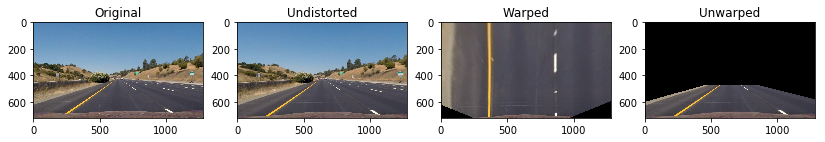

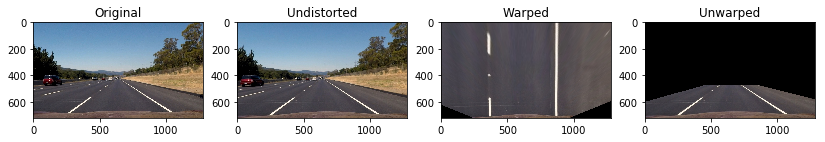

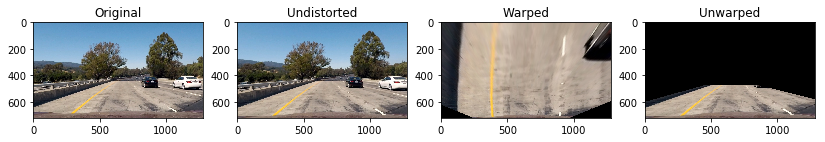

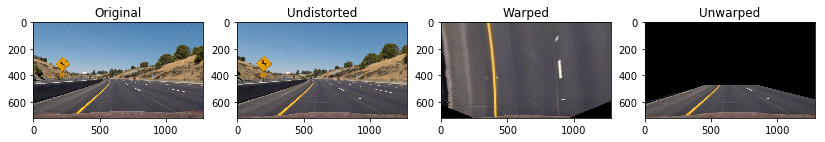

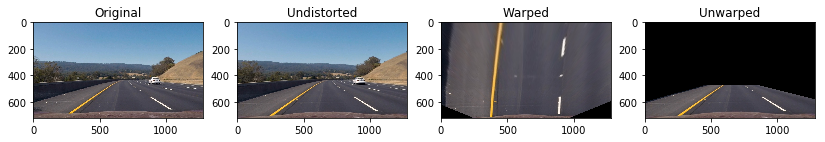

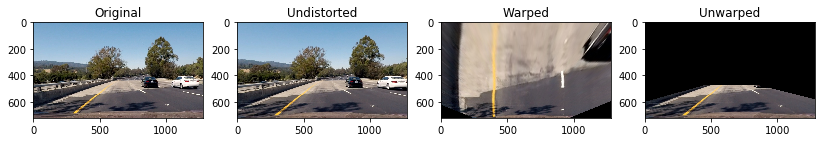

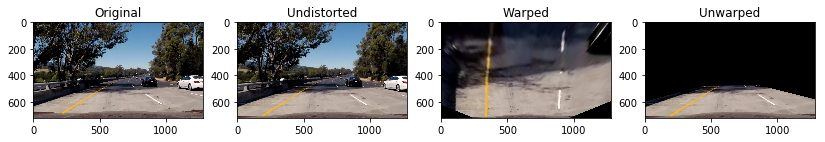

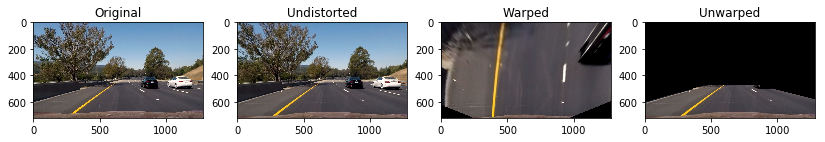

In [16]:
camera = Camera()
for test_img in glob('./test_images/*.jpg'):
    img = cv2.imread(test_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    f.set_figwidth(14)
    ax1.imshow(img)
    ax1.set_title('Original')
    undist = camera.undistort(img)
    ax2.imshow(undist)
    ax2.set_title('Undistorted')
    warped = camera.warp(undist)
    ax3.imshow(warped)
    ax3.set_title('Warped')
    unwarped = camera.unwarp(warped)
    ax4.imshow(unwarped)
    ax4.set_title('Unwarped')
    plt.show()

In [8]:
def color_filter(original):
    image = cv2.cvtColor(original, cv2.COLOR_RGB2HLS)
    white_mask = cv2.inRange(
        image,
        np.uint8([0, 200, 0]),
        np.uint8([255, 255, 255]),
    )
    yellow_mask = cv2.inRange(
        image,
        np.uint8([10, 0, 100]),
        np.uint8([40, 255, 255]),
    )
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return mask

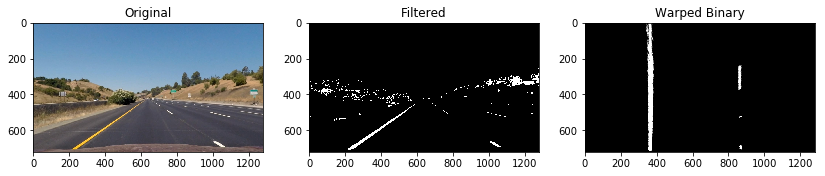

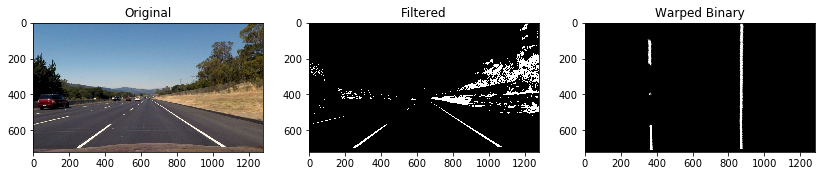

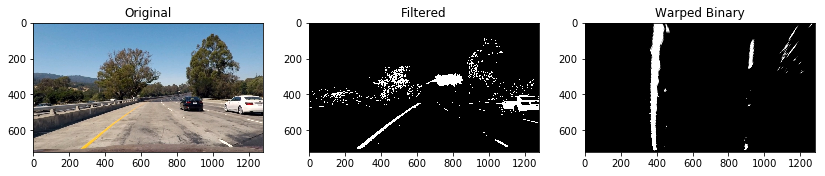

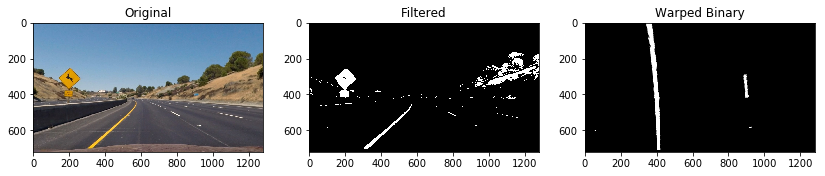

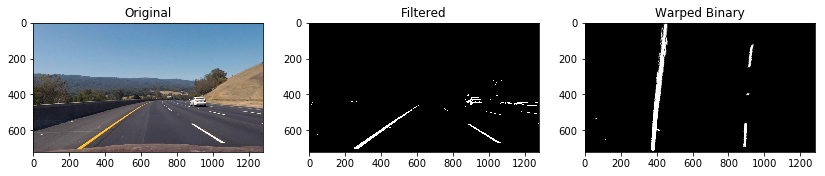

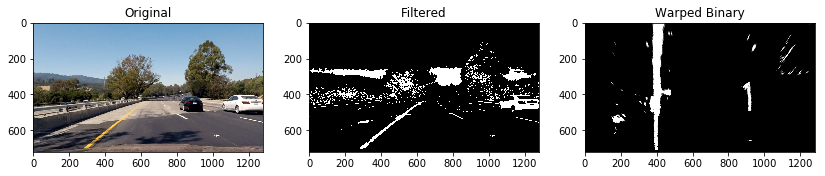

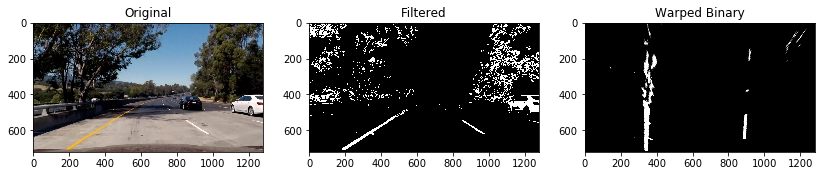

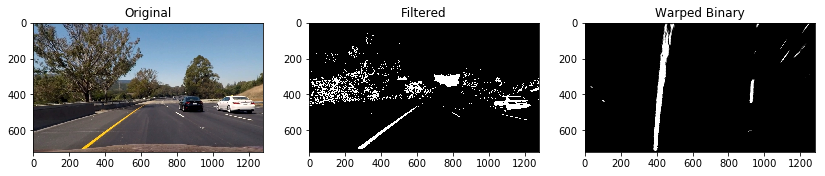

In [17]:
for test_img in glob('./test_images/*.jpg'):
    img = cv2.imread(test_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = camera.undistort(img)
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(14)
    ax1.imshow(img)
    ax1.set_title('Original')
    filtered = color_filter(img)
    ax2.imshow(filtered, cmap='gray')
    ax2.set_title('Filtered')
    ax3.imshow(camera.warp(filtered), cmap='gray')
    ax3.set_title('Warped Binary')
    plt.show()

In [18]:
def sliding_search(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[360:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    else:
        left_fit = None
        left_fitx = None

    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    else:
        right_fix = None
        right_fitx = None

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255 
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fitx, right_fitx, ploty, out_img

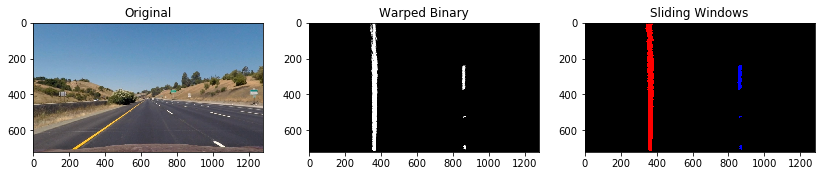

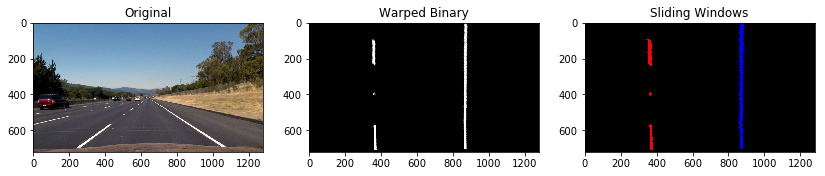

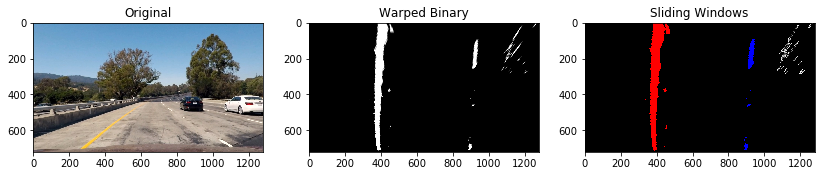

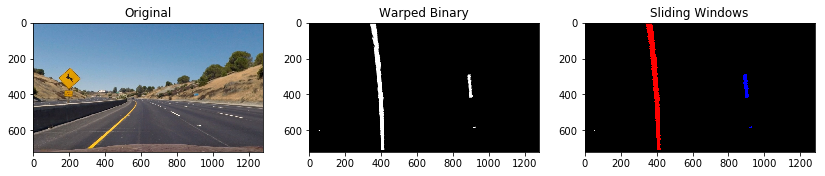

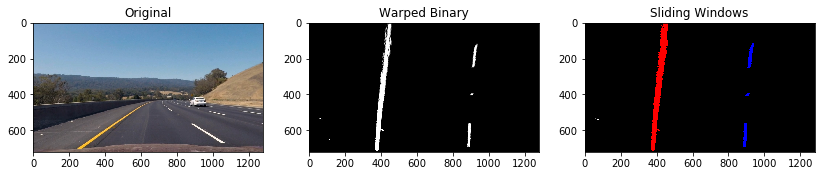

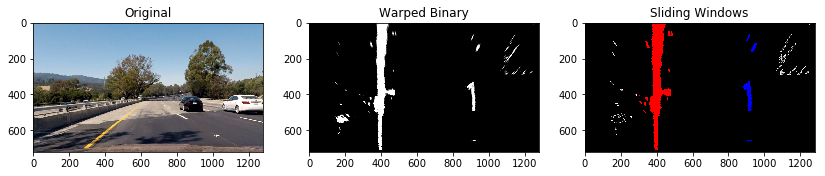

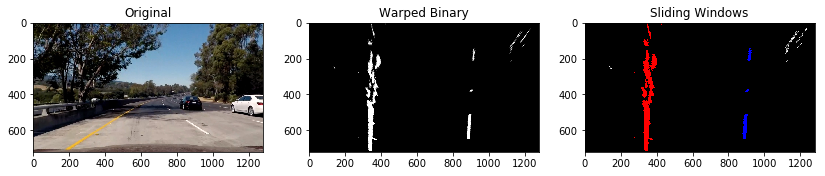

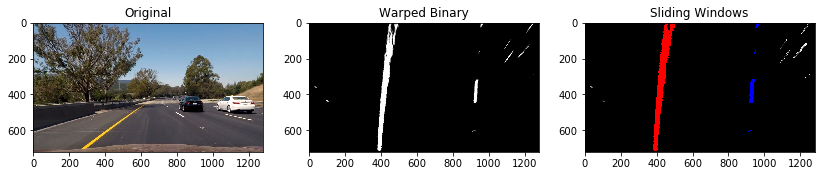

In [20]:
for test_img in glob('./test_images/*.jpg'):
    img = cv2.imread(test_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = camera.undistort(img)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(14)
    ax1.imshow(img)
    ax1.set_title('Original')
    
    filtered = color_filter(img)
    warped = camera.warp(filtered)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('Warped Binary')
    
    lfx, rfx, ploty, lanes = sliding_search(warped)
    ax3.imshow(lanes, cmap='gray')
    ax3.set_title('Sliding Windows')
    plt.show()

In [22]:
def calculate_curvature_deviation(left_fitx, right_fitx, ploty):
    lane_width = right_fitx[-1] - left_fitx[-1]
    x_mpp = 3.7/lane_width  # 3.7m lane width
    y_mpp = 30.0/720 # 30m for the whole height of the warped binary
    lane_center = (left_fitx[-1] + right_fitx[-1]) / 2 # Lane center in pixels
    deviation = (1280 / 2 - lane_center) * x_mpp # Deviation from center converted to meters
    
    left_fitxm = np.polyfit(ploty * y_mpp, left_fitx * x_mpp, 2)
    right_fitxm = np.polyfit(ploty * y_mpp, right_fitx * x_mpp, 2)
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fitxm[0]*y_eval*y_mpp + left_fitxm[1])**2)**1.5) / np.absolute(2*left_fitxm[0])
    right_curverad = ((1 + (2*right_fitxm[0]*y_eval*y_mpp + right_fitxm[1])**2)**1.5) / np.absolute(2*right_fitxm[0])
    return left_curverad, right_curverad, deviation

def draw_lanes(undist, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(undist).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

def plot_back(undist, filtered, warped, lanes, left_fitx, right_fitx, ploty):
    
    color_warp = draw_lanes(undist, left_fitx, right_fitx, ploty)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = camera.unwarp(color_warp)
    # Combine the result with the original image
    output = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
     
    h, w = undist.shape[:2]
    thumb_ratio = 0.2
    thumb_h, thumb_w = int(thumb_ratio * h), int(thumb_ratio * w)
    off_x, off_y = 20, 15

    # add a gray rectangle to highlight the upper area
    mask = undist.copy()
    mask = cv2.rectangle(mask, pt1=(0, 0), pt2=(w, thumb_h+2*off_y), color=(0, 0, 0), thickness=cv2.FILLED)
    output = cv2.addWeighted(src1=mask, alpha=0.2, src2=output, beta=0.8, gamma=0)

    # add thumbnail of binary image
    thumb_binary = cv2.resize(filtered * 255, dsize=(thumb_w, thumb_h))
    thumb_binary = np.dstack([thumb_binary, thumb_binary, thumb_binary]) * 255
    output[off_y:thumb_h+off_y, off_x:off_x+thumb_w, :] = thumb_binary

    # add thumbnail of bird's eye view
    thumb_birdeye = cv2.resize(warped, dsize=(thumb_w, thumb_h))
    thumb_birdeye = np.dstack([thumb_birdeye, thumb_birdeye, thumb_birdeye]) * 255
    output[off_y:thumb_h+off_y, 2*off_x+thumb_w:2*(off_x+thumb_w), :] = thumb_birdeye
    
    # add thumbnail of bird's eye view (lane-line highlighted)
    thumb_img_fit = cv2.resize(lanes, dsize=(thumb_w, thumb_h))
    output[off_y:thumb_h+off_y, 3*off_x+2*thumb_w:3*(off_x+thumb_w), :] = thumb_img_fit

    # add text (curvature and offset info) on the upper right of the blend
    # Annotate curvature and deviation
    left_curve, right_curve, deviation = calculate_curvature_deviation(left_fitx, right_fitx, ploty)
    mean_curvature_meter = int((left_curve + right_curve)/2)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(output, 'Curvature radius: {:.02f}m'.format(mean_curvature_meter), (860, 60), 
                font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(output, 'Deviation: {:.02f}m'.format(deviation), (860, 130), font, 0.9, (255, 255, 255), 2, cv2.LINE_AA)
    return output

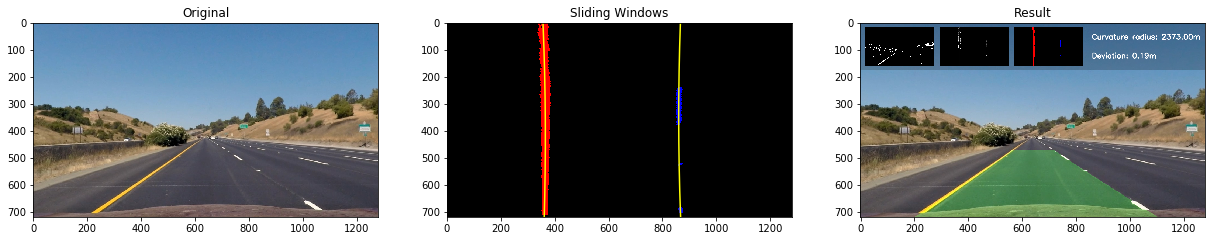

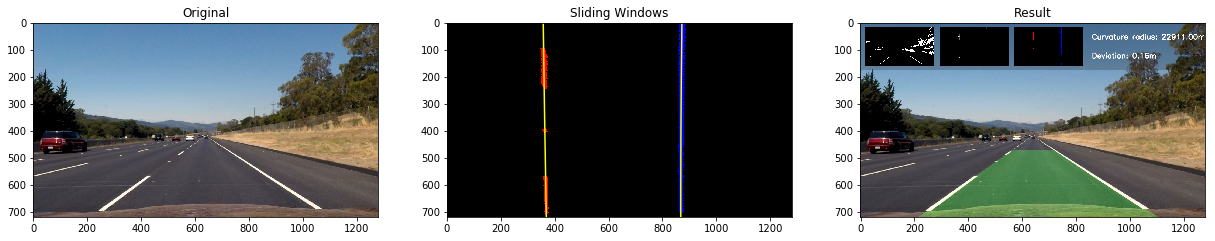

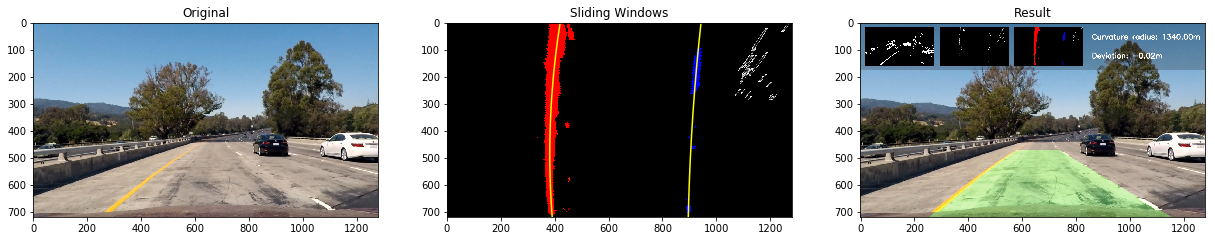

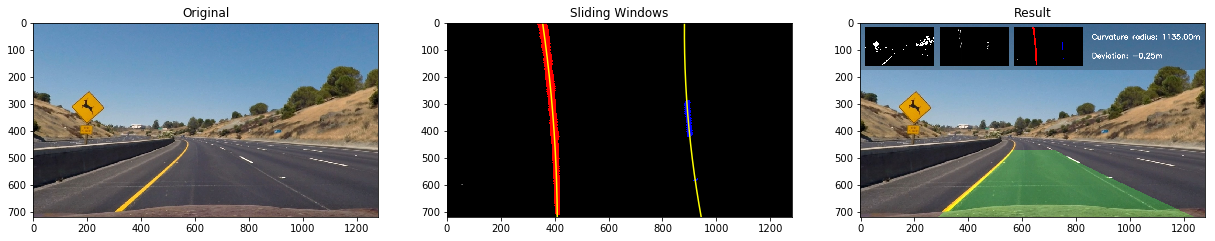

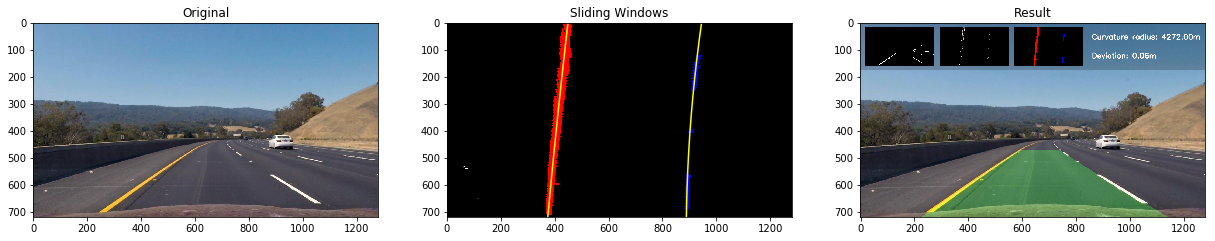

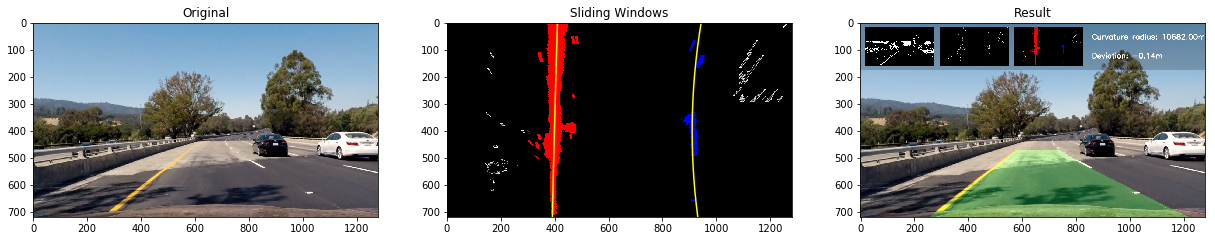

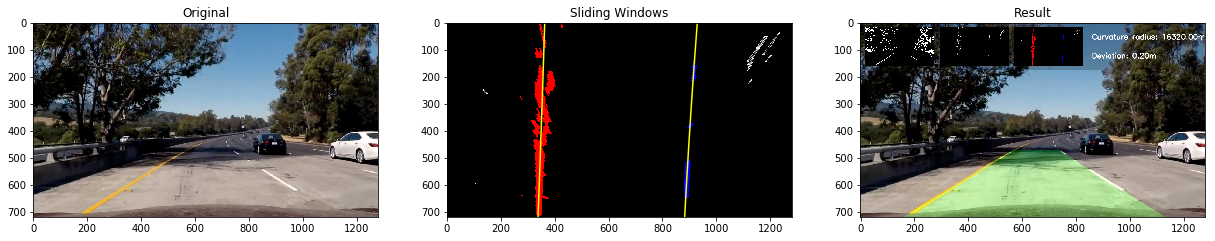

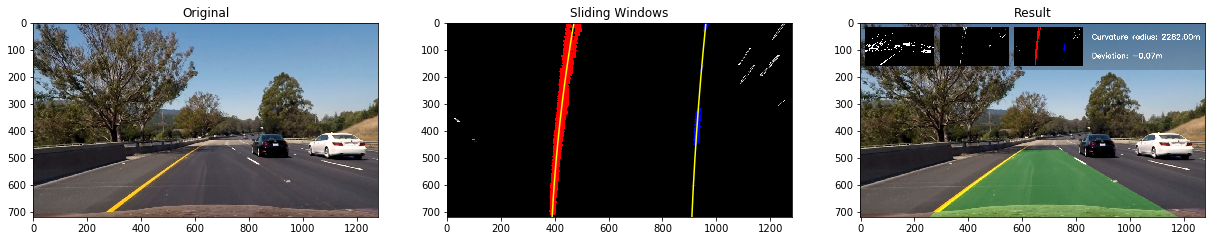

In [23]:
for test_img in glob('./test_images/*.jpg'):
    img = cv2.imread(test_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = camera.undistort(img)
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    f.set_figwidth(21)
    ax1.imshow(img)
    ax1.set_title('Original')
    
    filtered = color_filter(img)
    warped = camera.warp(filtered)
    lfx, rfx, ploty, lanes = sliding_search(warped)
    
    ax2.imshow(lanes, cmap='gray')
    ax2.plot(lfx, ploty, color='yellow')
    ax2.plot(rfx, ploty, color='yellow')
    ax2.set_title('Sliding Windows')
    
    ax3.imshow(plot_back(img, filtered, warped, lanes, lfx, rfx, ploty))
    ax3.set_title('Result')
    plt.show()

In [24]:
def process_frame(img):
    img = camera.undistort(img)
    filtered = color_filter(img)
    warped = camera.warp(filtered)
    lfx, rfx, ploty, lanes = sliding_search(warped)
    output = plot_back(img, filtered, warped, lanes, lfx, rfx, ploty)
    return output

In [25]:
input_video = 'project_video.mp4'
output_video = 'output_{}'.format(input_video)

clip = VideoFileClip(input_video)
clip.fl_image(process_frame).write_videofile(output_video, audio=False)

HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(output_video))

Moviepy - Building video output_project_video.mp4.
Moviepy - Writing video output_project_video.mp4



Moviepy - Done !
Moviepy - video ready output_project_video.mp4
